# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [61]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [62]:
from thinkstats2 import RandomSeed
RandomSeed(17)

In [16]:
def all_pairs(nodes):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

## Regular ring lattice

In [63]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

In [64]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


In [65]:
def make_ring_lattice(n, k):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

In [66]:
lattice = make_ring_lattice(10, 4)

Writing chap03-1.pdf
Writing chap03-1.eps


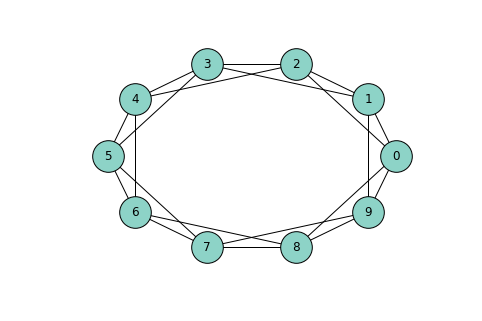

In [67]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)
thinkplot.save('chap03-1', clf=False)

## WS graph

In [68]:
from numpy.random import random
from numpy.random import choice

def flip(p):
    return random() < p

In [149]:
def rewire(G, p):
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            choices = nodes - {u} - set(G[u])
            new_v = choice(tuple(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)

In [150]:
def make_ws_graph(n, k, p):
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

In [151]:
ws = make_ws_graph(10, 4, 0.2)

In [152]:
len(lattice.edges()), len(ws.edges())

(20, 20)

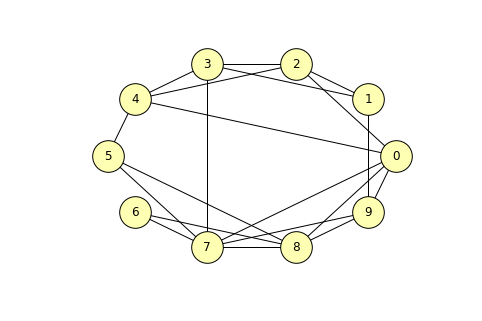

In [153]:
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Writing chap03-2.pdf
Writing chap03-2.eps


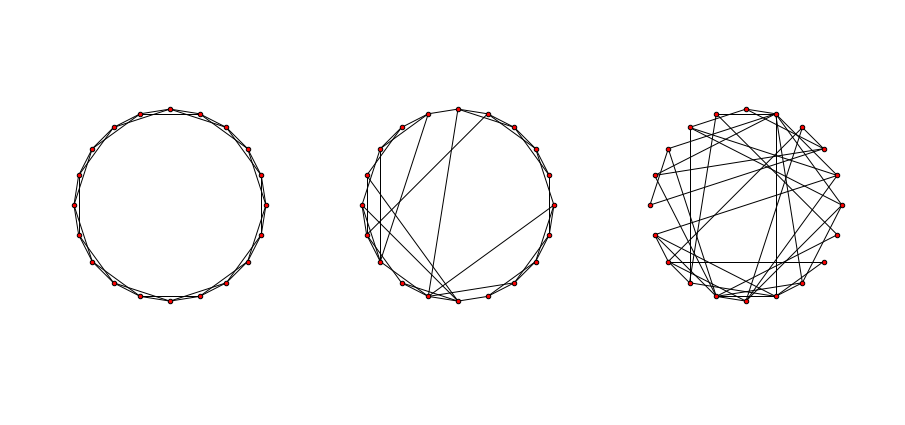

In [134]:
reload(thinkplot)

thinkplot.preplot(cols=3)
ws = make_ws_graph(20, 4, 0)
nx.draw_circular(ws, node_size=20)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(20, 4, 0.2)
nx.draw_circular(ws, node_size=20)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(20, 4, 1.0)
nx.draw_circular(ws, node_size=20)
thinkplot.config(axis='equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
thinkplot.save('chap03-2', clf=False)

**Exercise:** What is the order of growth of `rewire`?

Solution: The loop executes once for each edge.  Inside the loop, everything is constant time except computing `choices`, which is linear in n.  So the total run time is $O(nm)$.

## Clustering

In [242]:
def node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 1
        
    total = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / total

In [204]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

In [205]:
def clustering_coefficient(G):
    cc = np.mean([node_clustering(G, node) for node in G])
    return cc

In [206]:
clustering_coefficient(lattice)

0.5

**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.

In [209]:
def node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    edges = [G.has_edge(v, w) for v, w in all_pairs(neighbors)]
    return sum(edges) / len(edges)

In [210]:
node_clustering(lattice, 1)

0.5

**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

Solution: `clustering_coefficient` calls `node_clustering` once for each node.  `node_clustering` is quadratic in `k`, the number of neighbors.

In a complete graph, `k = n-1`, so `node_clustering` is $O(n^2)$ and `clustering_coefficient` is $O(n^3)$.

But in a ring lattice, or any other graph where `k` is not proportional to `n`, `clustering_coefficient` is $O(k^2 n)$.

## Path length

In [186]:
def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length_map[u][v] for u, v in all_pairs(G)]
    return lengths

In [187]:
def characteristic_path_length(G):
    return np.mean(path_lengths(G))

In [195]:
lattice = make_ring_lattice(3, 2)
characteristic_path_length(lattice)

1.0

In [196]:
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.6666666666666667

In [197]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

## The experiment

In [232]:
def run_one_graph(n, k, p):
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

In [233]:
%time run_one_graph(1000, 10, 0.01)

8.89284084084 0.646479292929
CPU times: user 1.15 s, sys: 52 ms, total: 1.2 s
Wall time: 1.13 s


(8.8928408408408401, 0.64647929292929296)

In [234]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


In [237]:
def run_experiment(ps, n=1000, k=10, iters=20):
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

In [243]:
res = run_experiment(ps)

0.0001
49.5923563564 0.666206565657
30.9185285285 0.665674242424
38.6795475475 0.666206565657
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
44.7613833834 0.666423232323
42.2448808809 0.666278787879
50.4504504505 0.666666666667
50.4504504505 0.666666666667
41.79396997 0.666206565657
33.0559439439 0.665890909091
38.5490890891 0.666351010101
38.8144604605 0.666278787879
50.4504504505 0.666666666667
50.4504504505 0.666666666667
45.2501281281 0.666206565657
50.4504504505 0.666666666667
50.4504504505 0.666666666667
0.000316227766017
34.5548648649 0.665647474747
50.4504504505 0.666666666667
50.4504504505 0.666666666667
32.0754474474 0.665358585859
31.8207247247 0.665746464646
48.7198258258 0.666278787879
38.7896456456 0.666351010101
50.4504504505 0.666666666667
34.9467407407 0.665214141414
50.4504504505 0.666666666667
31.5832692693 0.665674242424
26.2536536537 0.665016161616
50.4504504505 0.666666666667
38.5084404404 0.6662

In [244]:
L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
print(L)
print(C)

[45.408239639639646, 41.917368968968972, 26.707237337337336, 15.232011011011007, 8.9666055055055054, 5.9731369369369363, 4.4500205205205212, 3.5781968968968969, 3.2679904904904902]
[0.66641949494949482, 0.66614797979797957, 0.66440992424242418, 0.66041293290043279, 0.64753153318903323, 0.60827256549006559, 0.49219534493284495, 0.21912085327168535, 0.0089626321816298586]


In [245]:
L = np.array(L) / L[0]
C = np.array(C) / C[0]

Writing chap03-3.pdf
Writing chap03-3.eps


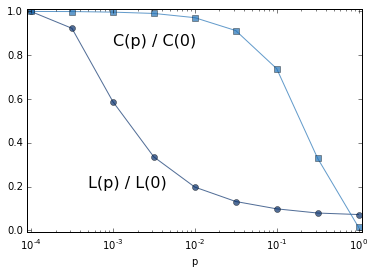

In [246]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])
thinkplot.save('chap03-3', clf=False)

## Breadth-first search

In [20]:
lattice = make_ring_lattice(10, 4)

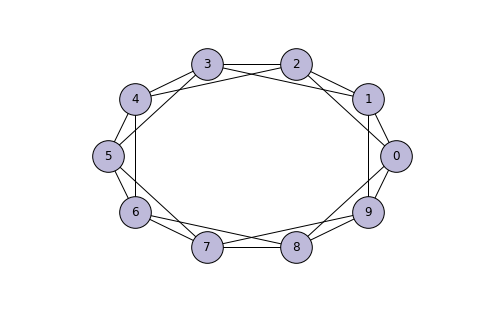

In [21]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

In [22]:
lattice.neighbors(2)

[0, 1, 3, 4]

In [258]:
from collections import deque

def reachable_nodes_bfs(G, start):
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

In [259]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [260]:
def reachable_nodes_bfs(G, start):
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) 
            neighbors -= seen
            queue.extend(neighbors)
    return seen

In [261]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

In [268]:
def shortest_path_dijkstra(G, start):
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

In [271]:
lattice = make_ring_lattice(10, 4)

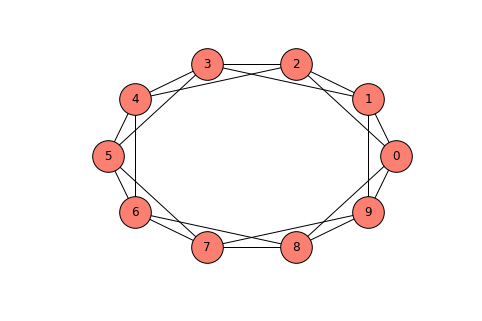

In [272]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

In [279]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

In [274]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

In [280]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [198]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

In [199]:
def opposite_edges(nodes):
    """Enumerates edges that connect opposite nodes."""
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v

In [200]:
def make_regular_graph(n, k):
    """Makes graph with `n` nodes where all nodes have `k` neighbors.
    
    Not possible if both `n` and `k` are odd.
    """
    # a is the number of adjacent edges
    # b is the number of opposite edges (0 or 1)
    a, b = divmod(k, 2)
    
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, a))
    
    # if k is odd, add opposite edges
    if b:
        if n%2:
            msg = "Can't make a regular graph if n and k are odd."
            raise ValueError(msg)
        G.add_edges_from(opposite_edges(nodes))
    return G

In [201]:
regular = make_regular_graph(10, 3)

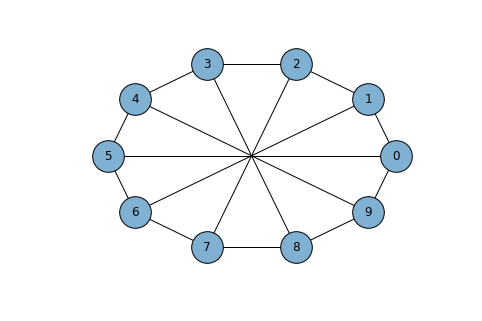

In [202]:
nx.draw_circular(regular, 
                 node_color=COLORS[4], 
                 node_size=1000, 
                 with_labels=True)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [285]:
def plain_bfs(G, source):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [42]:
lattice = make_ring_lattice(1000, 10)

In [43]:
%timeit len(reachable_nodes_bfs(lattice, 0))

100 loops, best of 3: 5.55 ms per loop


In [44]:
%timeit len(plain_bfs(lattice, 0))

1000 loops, best of 3: 742 µs per loop


In [45]:
def plain_shortest_path(G, source):
    """A fast implementation of Dijkstra's algorithm with equal edge lengths."""
    new_dist = 0
    dist = {}
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in dist:
                dist[v] = new_dist
                nextlevel.update(G[v])
        new_dist += 1
    return dist

In [48]:
d1 = shortest_path_dijkstra(lattice, 0)

In [49]:
d2 = plain_shortest_path(lattice, 0)

In [50]:
d1 == d2

True

In [51]:
%timeit shortest_path_dijkstra(lattice, 0)

100 loops, best of 3: 9.14 ms per loop


In [52]:
%timeit plain_shortest_path(lattice, 0)

1000 loops, best of 3: 719 µs per loop


In [53]:
%timeit nx.shortest_path_length(lattice, 0)

1000 loops, best of 3: 823 µs per loop


**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [ ]:
def bfs(top_node, visit):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [top_node]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visit(curr_node)            # Visit the node
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in curr_node.children
                     if c not in visited and c not in queue)

The first performance error is using `pop(0)` on a list, which is linear in the length of the list.  The second error is checking whether the children are in queue, which is also linear in the length of the list.  In the worst case, a completely connected graph, the queue loop runs `n` times, and each time we have to check `n` nodes to see if they are in a list with `n` elements, so the total run time is $O(n^3)$, which is really terrible.

By the way, I did not make this example up.  It used to be on [the Wikipedia page for BFS](https://en.wikipedia.org/wiki/Breadth-first_search).  In fact, if you search the Internet for Python implementations of BFS, many of them contain at least one performance error.

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [275]:
def shortest_path_dfs(G, start):
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.pop()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

In [282]:
d1 = shortest_path_dfs(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 5, 4: 4, 5: 3, 6: 3, 7: 2, 8: 1, 9: 1}

In [283]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

In [284]:
d1 == d2

False